In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Define functions to create a lognormal distribution given its median and either one or two quantiles

Note that since lognormal is a 2-parameter distribution, specifying the median and one other quantile will determine the distribution exactly, whereas specifying the median and two quantiles is an overdetermined system, so the resulting distribution in the second case will in general only approximate the specified quantiles.

In [2]:
np.log([3,4])

array([1.09861229, 1.38629436])

In [3]:
def lognorm_from_median_and_quantile(median, quantile, quantile_rank):
    """Returns a frozen lognormal distribution with the specified median and quantile
    of rank quantile_rank, which must be different from 0.5.
    """
    # Let Y ~ Norm(mu, sigma^2) and X = exp(Y), where mu = log(median)
    # so X ~ Lognorm(s=sigma, scale=exp(mu)) in scipy's notation.
    # We need to determine sigma from the median and quantile.
    
    # quantile of standard normal distribution corresponding to quantile_rank
    #(quantile is approximately 1.96 for quantile_rank=0.975)
    stdnorm_quantile = stats.norm().ppf(quantile_rank)

    mu = np.log(median) # mean of normal distribution for Y = log(X)
    sigma = (np.log(quantile) - mu) / stdnorm_quantile # std dev of normal distribution for Y=log(X)

    # Frozen lognormal distribution for X = exp(Y)
    # (s=sigma is the shape parameter; the scale parameter is exp(mu), which equals the median)
    return stats.lognorm(s=sigma, scale=median)

def lognorm_from_median_lower_upper(median, lower, upper, quantile_ranks=(0.025,0.975)):
    """Returns a frozen lognormal distribution with the specified median, such that
    (lower, upper) are approximately equal to the quantiles with ranks
    (quantile_ranks[0], quantile_ranks[1]).
    """
    # Let Y ~ Norm(mu, sigma^2) and X = exp(Y), where mu = log(median)
    # so X ~ Lognorm(s=sigma, scale=exp(mu)) in scipy's notation.
    # We will determine sigma from the two specified quantiles lower and upper.
    
    # mean (and median) of the normal random variable Y = log(X)
    mu = np.log(median)
    # quantiles of the standard normal distribution corresponding to quantile_ranks
    stdnorm_quantiles = stats.norm.ppf(quantile_ranks)
    # quantiles of Y = log(X) corresponding to the quantiles (lower, upper) for X
    norm_quantiles = np.log([lower, upper])
    # standard deviation of Y = log(X) computed from the above quantiles for Y
    # and the corresponding standard normal quantiles
    sigma = (norm_quantiles[1] - norm_quantiles[0]) / (stdnorm_quantiles[1] - stdnorm_quantiles[0])
    # Frozen lognormal distribution for X = exp(Y)
    # (s=sigma is the shape parameter; the scale parameter is exp(mu), which equals the median)
    return stats.lognorm(s=sigma, scale=median)


# Check some standard normal quantiles

In [4]:
stats.norm.ppf(0.975)

1.959963984540054

In [5]:
stats.norm.ppf(0.975) - stats.norm.ppf(0.025)

3.9199279690801085

# Create 3 slightly different lognormal distributions for K parameter from Isanaka paper

In [6]:
median = 6.7
lower = 5.3
upper = 8.4

dist_lower = lognorm_from_median_and_quantile(median, lower, 0.025)
dist_upper = lognorm_from_median_and_quantile(median, upper, 0.975)
dist_both = lognorm_from_median_lower_upper(median, lower, upper)

# Verify that the median is 6.7 for all three

In [7]:
print([dist.median() for dist in [dist_lower, dist_upper, dist_both]])

[6.7, 6.7, 6.7]


# Check mean, variance, skew, kurtosis for each version

In [8]:
dist_lower.stats('mvsk')

(array(6.74808618), array(0.65598273), array(0.36179892), array(0.2336203))

In [9]:
dist_upper.stats('mvsk')

(array(6.74473924), array(0.60956738), array(0.34882084), array(0.21710108))

In [10]:
dist_both.stats('mvsk')

(array(6.74639747), array(0.6325494), array(0.35530706), array(0.22528056))

# Check 95% interval = `(dist.ppf(0.025), dist.ppf(0.975))` for each version

In [11]:
dist_lower.interval(.95)

(5.299999999999999, 8.469811320754719)

In [12]:
dist_upper.interval(.95)

(5.34404761904762, 8.399999999999999)

In [13]:
dist_both.interval(.95)

(5.321978239428678, 8.434833436075643)

In [14]:
dist_upper.ppf(.975)

8.399999999999999

# Plot densities

In [15]:
def plot_pdf(ax, dist, label):
    x = np.linspace(dist.ppf(0.01), dist.ppf(0.99), 100)
    ax.plot(x, dist.pdf(x), lw=2, alpha=0.8, label=label)

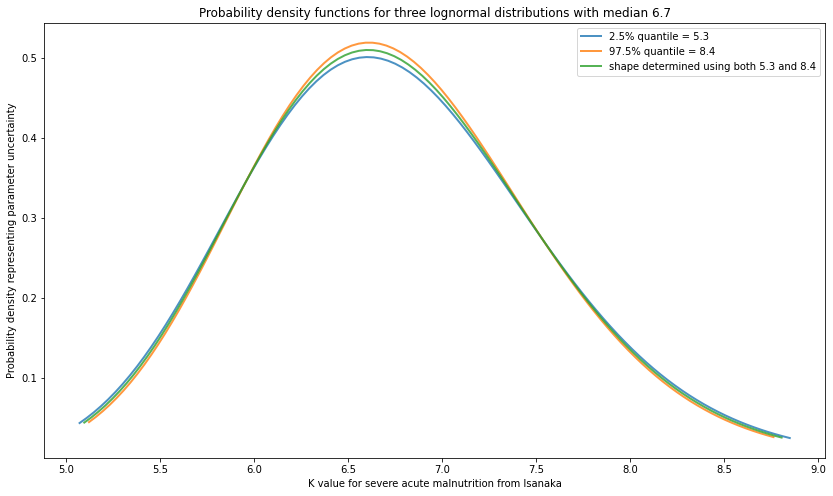

In [16]:
fig, ax = plt.subplots(figsize=(14,8))
plot_pdf(ax, dist_lower, '2.5% quantile = 5.3')
plot_pdf(ax, dist_upper, '97.5% quantile = 8.4')
plot_pdf(ax, dist_both, 'shape determined using both 5.3 and 8.4')
ax.legend()
ax.set_title("Probability density functions for three lognormal distributions with median 6.7")
ax.set_xlabel('K value for severe acute malnutrition from Isanaka')
ax.set_ylabel('Probability density representing parameter uncertainty');

# Let's go with the distribution that uses both 5.3 and 8.4 since it's in between